# Temporal-Difference Methods

In this notebook, you will write your own implementations of many Temporal-Difference (TD) methods.

While we have provided some starter code, you are welcome to erase these hints and write your code from scratch.

---

### Part 0: Explore CliffWalkingEnv

We begin by importing the necessary packages.

In [1]:
import sys
import gym
import numpy as np
from collections import defaultdict, deque
import matplotlib.pyplot as plt
%matplotlib inline

import check_test
from plot_utils import plot_values

Use the code cell below to create an instance of the [CliffWalking](https://github.com/openai/gym/blob/master/gym/envs/toy_text/cliffwalking.py) environment.

In [2]:
env = gym.make('CliffWalking-v0')

/usr/local/lib/python3.8/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.8/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(


The agent moves through a $4\times 12$ gridworld, with states numbered as follows:
```
[[ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11],
 [12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23],
 [24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35],
 [36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47]]
```
At the start of any episode, state `36` is the initial state.  State `47` is the only terminal state, and the cliff corresponds to states `37` through `46`.

The agent has 4 potential actions:
```
UP = 0
RIGHT = 1
DOWN = 2
LEFT = 3
```

Thus, $\mathcal{S}^+=\{0, 1, \ldots, 47\}$, and $\mathcal{A} =\{0, 1, 2, 3\}$.  Verify this by running the code cell below.

In [3]:
nA = env.action_space.n
nO = env.observation_space.n
print(nA)#env.action_space)
print(nO)


4
48


In this mini-project, we will build towards finding the optimal policy for the CliffWalking environment.  The optimal state-value function is visualized below.  Please take the time now to make sure that you understand _why_ this is the optimal state-value function.

_**Note**: You can safely ignore the values of the cliff "states" as these are not true states from which the agent can make decisions.  For the cliff "states", the state-value function is not well-defined._

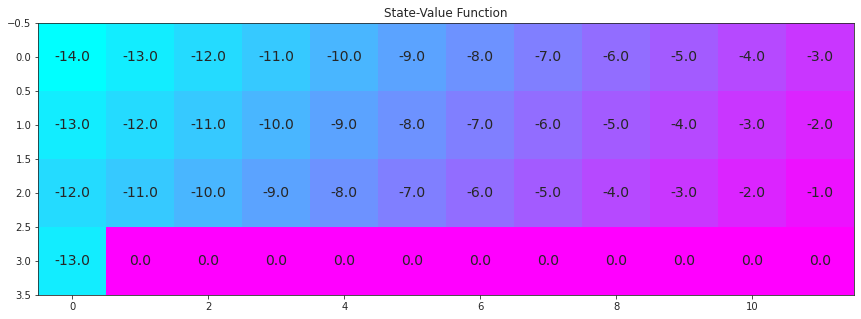

In [4]:
# define the optimal state-value function
V_opt = np.zeros((4,12))
V_opt[0:13][0] = -np.arange(3, 15)[::-1]
V_opt[0:13][1] = -np.arange(3, 15)[::-1] + 1
V_opt[0:13][2] = -np.arange(3, 15)[::-1] + 2
V_opt[3][0] = -13

plot_values(V_opt)

In [ ]:
-np.arange(3, 15)[::-1] + 2

In [6]:
pol_opt = np.hstack((np.ones(11), 2, 0))

V_true = np.zeros((4,12))
for i in range(3):
    V_true[0:13][i] = -np.arange(3, 15)[::-1] - i
V_true[1][11] = -2
V_true[2][11] = -1
V_true[3][0] = -17

UP = 0
RIGHT = 1
DOWN = 2
LEFT = 3

In [ ]:
pol_opt

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 2., 0.])

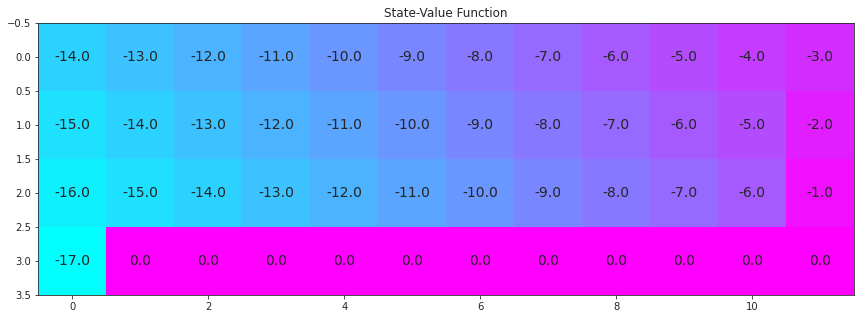

In [7]:
plot_values(V_true)

### Part 1: TD Control: Sarsa

In this section, you will write your own implementation of the Sarsa control algorithm.

Your algorithm has four arguments:
- `env`: This is an instance of an OpenAI Gym environment.
- `num_episodes`: This is the number of episodes that are generated through agent-environment interaction.
- `alpha`: This is the step-size parameter for the update step.
- `gamma`: This is the discount rate.  It must be a value between 0 and 1, inclusive (default value: `1`).

The algorithm returns as output:
- `Q`: This is a dictionary (of one-dimensional arrays) where `Q[s][a]` is the estimated action value corresponding to state `s` and action `a`.

Please complete the function in the code cell below.

(_Feel free to define additional functions to help you to organize your code._)

In [18]:
def greedy_action(epsilon, a_values):
    # Epsilon-greedy policy for actions
        p = [1-epsilon, epsilon]
        policy_choice = np.random.choice([True, False], p=p)
        if policy_choice:
            action = int(np.argmax(a_values))
            #action = policy[state]
        else:
            action = np.random.randint(0,nA)
        return action

In [56]:
def sarsa(env, num_episodes, alpha, Q=None, gamma=1.0):
    # initialize action-value function (empty dictionary of arrays)
    if Q == None:
        Q = defaultdict(lambda: np.zeros(env.nA))
    # initialize epsilon decay parameters
    epsilon_decay = 0.995
    epsilon_min = 0.05
    # loop over num_episodes
    for i_episode in range(1, num_episodes+1):
        # monitor progress
        if i_episode % 100 == 0:
            print("\rEpisode {}/{}".format(i_episode, num_episodes), end="")
            sys.stdout.flush()   
        # initialize for each new episode
        epsilon = 1.0
        s = env.reset()
        a = greedy_action(epsilon, Q[s])
        done = False
        # Cycle through steps until endpoint is reached
        # According to SARSA algorithm
        while not done:
            next_s, r, done, _ = env.step(a)
            next_a = greedy_action(epsilon, Q[next_s])
            epsilon = np.max([epsilon*epsilon_decay, epsilon_min])
            Q[s][a] = Q[s][a] + alpha*(r + gamma*Q[next_s][next_a] - Q[s][a])
            s = next_s
            a = next_a
    return Q

In [ ]:
# obtain the estimated optimal policy and action-value function
init_policy = defaultdict(lambda: np.ones(1, dtype=np.int8))
#Q = defaultdict(lambda: np.random.randint(0, env.nA, (env.nA,)))
init_Q = defaultdict(lambda: np.zeros(env.nA))
for s in range(nO):
    init_Q[s] = np.random.uniform(-np.pi, np.pi, (nA,))
    init_policy[s] = np.argmax(init_Q[s])

init_Q

Use the next code cell to visualize the **_estimated_** optimal policy and the corresponding state-value function.  

If the code cell returns **PASSED**, then you have implemented the function correctly!  Feel free to change the `num_episodes` and `alpha` parameters that are supplied to the function.  However, if you'd like to ensure the accuracy of the unit test, please do not change the value of `gamma` from the default.

Episode 10000/10000

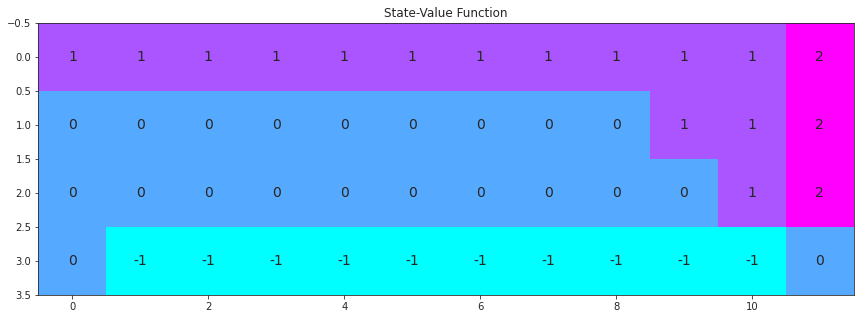

In [52]:
# obtain the estimated optimal policy and corresponding action-value function
Q_sarsa = defaultdict(lambda: np.zeros(env.nA))
Q_sarsa = sarsa(env, 10000, .02, Q_sarsa)
policy_sarsa = np.array([np.argmax(Q_sarsa[key]) if key in Q_sarsa else -1 for key in np.arange(48)]).reshape(4,12)
plot_values(policy_sarsa)

**<span style="color: red;">PLEASE TRY AGAIN</span>**


Estimated Optimal Policy (UP = 0, RIGHT = 1, DOWN = 2, LEFT = 3, N/A = -1):
[[ 1  1  1  1  1  1  1  1  1  1  1  2]
 [ 0  0  0  0  0  0  0  0  0  1  1  2]
 [ 0  0  0  0  0  0  0  0  0  0  1  2]
 [ 0 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  0]]


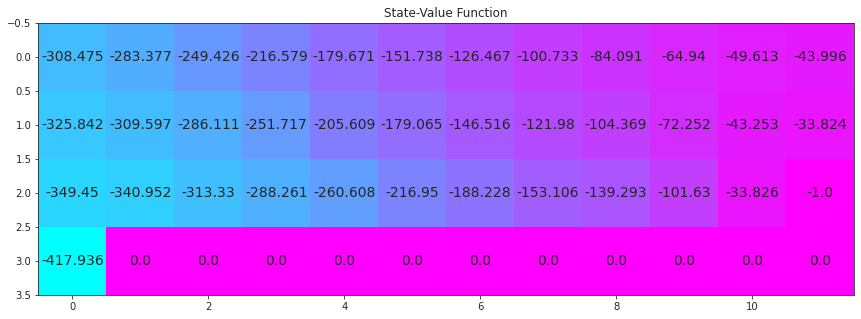

In [53]:
# print the estimated optimal policy
#policy_sarsa = np.array([np.argmax(Q_sarsa[key]) if key in Q_sarsa else -1 for key in np.arange(48)]).reshape(4,12)
check_test.run_check('td_control_check', policy_sarsa)
print("\nEstimated Optimal Policy (UP = 0, RIGHT = 1, DOWN = 2, LEFT = 3, N/A = -1):")
print(policy_sarsa)

# plot the estimated optimal state-value function
V_sarsa = ([np.max(Q_sarsa[key]) if key in Q_sarsa else 0 for key in np.arange(48)])
plot_values(V_sarsa)

### Part 2: TD Control: Q-learning

In this section, you will write your own implementation of the Q-learning control algorithm.

Your algorithm has four arguments:
- `env`: This is an instance of an OpenAI Gym environment.
- `num_episodes`: This is the number of episodes that are generated through agent-environment interaction.
- `alpha`: This is the step-size parameter for the update step.
- `gamma`: This is the discount rate.  It must be a value between 0 and 1, inclusive (default value: `1`).

The algorithm returns as output:
- `Q`: This is a dictionary (of one-dimensional arrays) where `Q[s][a]` is the estimated action value corresponding to state `s` and action `a`.

Please complete the function in the code cell below.

(_Feel free to define additional functions to help you to organize your code._)

In [57]:
def q_learning(env, num_episodes, alpha, Q=None, gamma=1.0):
    # initialize action-value function (empty dictionary of arrays)
    if Q == None:
        Q = defaultdict(lambda: np.zeros(env.nA))
    # initialize epsilon decay parameters
    epsilon_decay = 0.995
    epsilon_min = 0.05
    # loop over episodes
    for i_episode in range(1, num_episodes+1):
        # monitor progress
        if i_episode % 100 == 0:
            print("\rEpisode {}/{}".format(i_episode, num_episodes), end="")
            sys.stdout.flush()
        # initialize for each new episode
        epsilon = 1.0
        s = env.reset()
        done = False
        # Cycle through steps until endpoint is reached
        # According to sarsamax algorithm
        while not done:
            a = greedy_action(epsilon, Q[s])
            epsilon = np.max([epsilon*epsilon_decay, epsilon_min])
            next_s, r, done, _ = env.step(a)
            Q[s][a] = Q[s][a] + alpha*(r + gamma*np.max(Q[next_s]) - Q[s][a])
            s = next_s  
    return Q

Use the next code cell to visualize the **_estimated_** optimal policy and the corresponding state-value function. 

If the code cell returns **PASSED**, then you have implemented the function correctly!  Feel free to change the `num_episodes` and `alpha` parameters that are supplied to the function.  However, if you'd like to ensure the accuracy of the unit test, please do not change the value of `gamma` from the default.

In [58]:
# obtain the estimated optimal policy and corresponding action-value function
Q_sarsamax = q_learning(env, 5000, .01)

Episode 5000/5000

**<span style="color: green;">PASSED</span>**


Estimated Optimal Policy (UP = 0, RIGHT = 1, DOWN = 2, LEFT = 3, N/A = -1):
[[ 1  1  1  1  1  1  1  1  1  1  2  2]
 [ 1  1  1  1  1  1  1  2  2  1  2  2]
 [ 1  1  1  1  1  1  1  1  1  1  1  2]
 [ 0 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  0]]


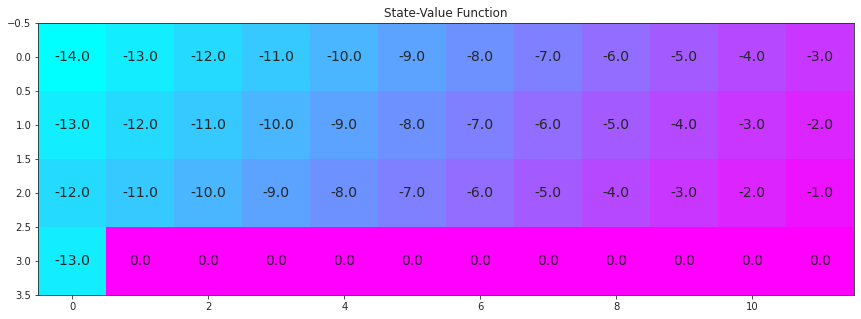

In [59]:


# print the estimated optimal policy
policy_sarsamax = np.array([np.argmax(Q_sarsamax[key]) if key in Q_sarsamax else -1 for key in np.arange(48)]).reshape((4,12))
check_test.run_check('td_control_check', policy_sarsamax)
print("\nEstimated Optimal Policy (UP = 0, RIGHT = 1, DOWN = 2, LEFT = 3, N/A = -1):")
print(policy_sarsamax)

# plot the estimated optimal state-value function
plot_values([np.max(Q_sarsamax[key]) if key in Q_sarsamax else 0 for key in np.arange(48)])

### Part 3: TD Control: Expected Sarsa

In this section, you will write your own implementation of the Expected Sarsa control algorithm.

Your algorithm has four arguments:
- `env`: This is an instance of an OpenAI Gym environment.
- `num_episodes`: This is the number of episodes that are generated through agent-environment interaction.
- `alpha`: This is the step-size parameter for the update step.
- `gamma`: This is the discount rate.  It must be a value between 0 and 1, inclusive (default value: `1`).

The algorithm returns as output:
- `Q`: This is a dictionary (of one-dimensional arrays) where `Q[s][a]` is the estimated action value corresponding to state `s` and action `a`.

Please complete the function in the code cell below.

(_Feel free to define additional functions to help you to organize your code._)

In [63]:
def expected_value(counts, values):
    expected = sum(c*v for c,v in zip(counts, values)) / np.sum(counts) if np.sum(counts) > 0. else 0.
    return expected

In [64]:
Q_sarsamax[9]

array([-5.9990897 , -4.99999875, -4.99999877, -6.99877607])

In [68]:
def expected_sarsa(env, num_episodes, alpha, Q=None, gamma=1.0):
    # initialize action-value function (empty dictionary of arrays)
    if Q == None:
        Q = defaultdict(lambda: np.zeros(env.nA))
    # count of visits for calculating expected action value for each state
    action_counts = defaultdict(lambda: np.zeros(env.nA))
    # initialize epsilon decay parameters
    epsilon_decay = 0.995
    epsilon_min = 0.05
    # loop over episodes
    for i_episode in range(1, num_episodes+1):
        # monitor progress
        if i_episode % 100 == 0:
            print("\rEpisode {}/{}".format(i_episode, num_episodes), end="")
            sys.stdout.flush()
        # initialize for each new episode
        epsilon = 1.0
        s = env.reset()
        done = False
        # Cycle through steps until endpoint is reached
        # According to expected_sarsa algorithm
        while not done:
            a = greedy_action(epsilon, Q[s])
            action_counts[s][a] += 1
            epsilon = np.max([epsilon*epsilon_decay, epsilon_min])
            next_s, r, done, _ = env.step(a)
            Q[s][a] = Q[s][a] + alpha*(r + gamma*expected_value(action_counts[next_s], Q[next_s]) - Q[s][a])
            s = next_s  
    return Q, action_counts

Use the next code cell to visualize the **_estimated_** optimal policy and the corresponding state-value function.  

If the code cell returns **PASSED**, then you have implemented the function correctly!  Feel free to change the `num_episodes` and `alpha` parameters that are supplied to the function.  However, if you'd like to ensure the accuracy of the unit test, please do not change the value of `gamma` from the default.

In [70]:
# obtain the estimated optimal policy and corresponding action-value function
Q_expsarsa, counts = expected_sarsa(env, 5000, 1., Q_expsarsa)



Episode 5000/5000

In [76]:
i = 0
expect = expected_value(counts[i], Q_sarsamax[i])
counts[i], Q_sarsamax[i], expect

(array([ 5712., 11262.,  5872.,  5904.]),
 array([-14.99987166, -13.99994992, -13.99999635, -14.99987909]),
 -14.403964093468314)

**<span style="color: red;">PLEASE TRY AGAIN</span>**


Estimated Optimal Policy (UP = 0, RIGHT = 1, DOWN = 2, LEFT = 3, N/A = -1):
[[ 1  1  1  1  1  1  1  1  1  1  1  2]
 [ 0  0  0  0  0  0  0  0  0  1  1  2]
 [ 0  0  0  0  0  0  0  0  0  0  1  2]
 [ 0 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  0]]


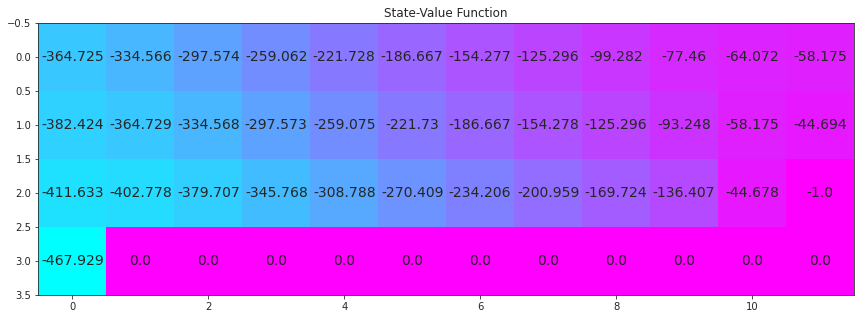

In [67]:
# obtain the estimated optimal policy and corresponding action-value function
#Q_expsarsa = expected_sarsa(env, 10000, 1)

# print the estimated optimal policy
policy_expsarsa = np.array([np.argmax(Q_expsarsa[key]) if key in Q_expsarsa else -1 for key in np.arange(48)]).reshape(4,12)
check_test.run_check('td_control_check', policy_expsarsa)
print("\nEstimated Optimal Policy (UP = 0, RIGHT = 1, DOWN = 2, LEFT = 3, N/A = -1):")
print(policy_expsarsa)

# plot the estimated optimal state-value function
plot_values([np.max(Q_expsarsa[key]) if key in Q_expsarsa else 0 for key in np.arange(48)])